In [105]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [106]:
with open('processed_corpus.json', encoding = 'utf-8') as f:
    corpus = json.load(f)

In [107]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [108]:
from torch.utils.data import Dataset, DataLoader

class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        #self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):
        return len(self.data)

    def _split_function(self, tokenized_text):     
        splits = []
        for ind, token in enumerate(tokenized_text):
            if self.window > ind:
                for i in range(0, ind):
                    splits.append((tokenized_text[i], token))
            else:
                for i in range(ind - self.window, ind):
                    splits.append((tokenized_text[i], token))
            if self.window > len(tokenized_text) - ind - 1:
                for i in range(ind+1, len(tokenized_text)):
                    splits.append((tokenized_text[i], token))
            else:
                for i in range(ind + 1, ind + self.window + 1):
                    splits.append((tokenized_text[i], token))
        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):
        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)
            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]

        return context, central_word

In [109]:
dataset = SkipgramDataset(corpus, word2index)
import pickle
f = open(r'file.txt', 'wb')
pickle.dump(dataset, f)
f.close()

100%|██████████| 100000/100000 [00:01<00:00, 52612.72it/s]


При обучении увеличила batch size, увеличила lr, увеличила длину эмбеддинга и кол-во эпох. В результате mse уменьшился в два раза:

In [110]:
BATCH_SIZE = 812
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [111]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

In [112]:
EMBEDDING_DIM = 30
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
model=model.to(device = 'cuda')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [113]:
epochs = 15

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            x = x.view(x.shape[0], -1).to(device = 'cuda')
            y = y.to(device = 'cuda')
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            
            loss.backward()

            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 15: 100%|██████████| 2983124/2983124 [00:32<00:00, 90727.64it/s, loss=6.67]


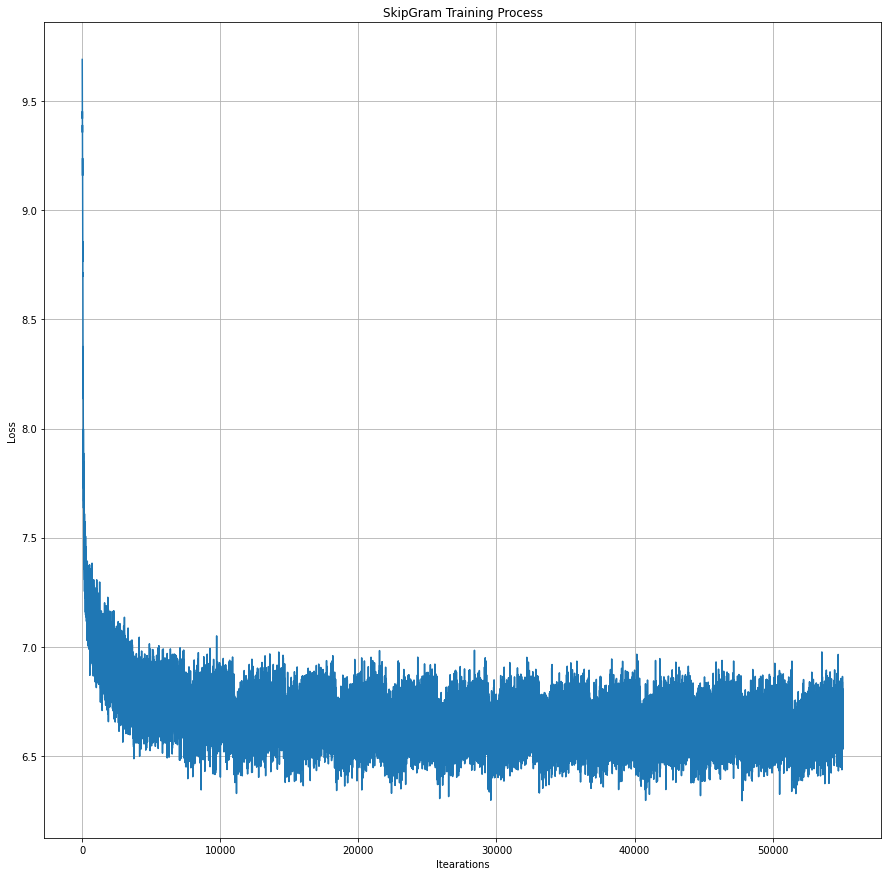

In [114]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [115]:
print(np.mean(losses[-1000:]))

6.657708114147186


In [116]:
embedding_matrix = model.in_embedding.weight.detach()

In [117]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    if word1 in token2id:
        i1 = token2id[word1]
    else:
        i1 = token2id['UNK']
    if word2 in token2id:
        i2 = token2id[word2]
    else:
        i2 = token2id['UNK']
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

In [57]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.8399720788002014

In [58]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.6889187097549438

In [59]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.8865103721618652

In [60]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.49937281012535095

In [118]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
data = pd.read_csv('ru_simlex965_tagged.tsv', sep = '\t')
sims = np.array(data['Average Score'].values)
norm_sims = sims / 10
words1 = [x.split('_')[0] for x in data['# Word1'].values]
words2 = [x.split('_')[0] for x in data['Word2'].values]
my_sims = []
for i in range(len(words1)):
    my_sims.append(cos_sim(embedding_matrix, word2index, words1[i], words2[i]))
print(mean_squared_error(my_sims, norm_sims))


0.1678179523241035


In [119]:
EMBEDDING_DIM = 10
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
model=model.to(device = 'cuda')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [120]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            x = x.view(x.shape[0], -1).to(device = 'cuda')
            y = y.to(device = 'cuda')
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            
            loss.backward()

            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [00:32<00:00, 92303.45it/s, loss=8.42]


In [122]:
embedding_matrix = model.in_embedding.weight.detach()
my_sims = []
for i in range(len(words1)):
    my_sims.append(cos_sim(embedding_matrix, word2index, words1[i], words2[i]))
print(mean_squared_error(my_sims, norm_sims))

0.32745975877985517
